# Setup GPU

In [1]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

# Remove dodgy images

In [7]:
import cv2
import imghdr

In [8]:
data_dir = 'Dataset' 

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [12]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

# Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [14]:
data = tf.keras.utils.image_dataset_from_directory('Dataset')

Found 713 files belonging to 2 classes.


In [15]:
data_iterator = data.as_numpy_iterator()

In [16]:
batch = data_iterator.next()

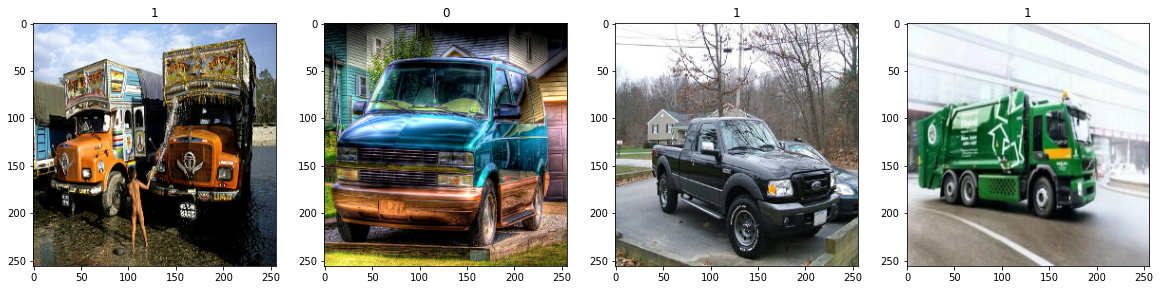

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Scale Data

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()

(array([[[[5.13867438e-01, 5.57004690e-01, 5.76428711e-01],
          [5.04598677e-01, 5.47735929e-01, 5.67159951e-01],
          [5.05575955e-01, 5.48713207e-01, 5.68137228e-01],
          ...,
          [1.09851554e-01, 1.24807559e-01, 4.25977521e-02],
          [1.35975316e-01, 1.53466076e-01, 6.03687949e-02],
          [2.41043150e-01, 2.56782562e-01, 1.32392198e-01]],
 
         [[5.01865745e-01, 5.52846134e-01, 5.84218681e-01],
          [4.99797493e-01, 5.50777912e-01, 5.82150459e-01],
          [5.03155649e-01, 5.54136038e-01, 5.85508585e-01],
          ...,
          [9.56636295e-02, 9.27224532e-02, 2.25159880e-02],
          [1.03656366e-01, 1.02703974e-01, 2.14566104e-02],
          [1.24240771e-01, 1.18474744e-01, 2.08800081e-02]],
 
         [[5.04161656e-01, 5.55142045e-01, 5.78671455e-01],
          [5.07981241e-01, 5.58961630e-01, 5.82491040e-01],
          [5.09380519e-01, 5.60360909e-01, 5.83890319e-01],
          ...,
          [7.07390308e-02, 5.42255491e-02, 1.3425

# Split Dataset

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [23]:
train_size

16

In [24]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Model

In [25]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Train

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
16/16 [==============================] - 14s 728ms/step - loss: 1.0607 - accuracy: 0.5117 - val_loss: 0.6901 - val_accuracy: 0.5469
Epoch 2/20
16/16 [==============================] - 12s 701ms/step - loss: 0.6817 - accuracy: 0.5586 - val_loss: 0.6765 - val_accuracy: 0.6172
Epoch 3/20
16/16 [==============================] - 12s 707ms/step - loss: 0.6779 - accuracy: 0.5645 - val_loss: 0.6579 - val_accuracy: 0.5859
Epoch 4/20
16/16 [==============================] - 12s 692ms/step - loss: 0.6542 - accuracy: 0.6133 - val_loss: 0.6552 - val_accuracy: 0.6406
Epoch 5/20
16/16 [==============================] - 12s 698ms/step - loss: 0.6234 - accuracy: 0.6328 - val_loss: 0.6180 - val_accuracy: 0.6875
Epoch 6/20
16/16 [==============================] - 12s 718ms/step - loss: 0.6070 - accuracy: 0.6680 - val_loss: 0.5926 - val_accuracy: 0.6719
Epoch 7/20
16/16 [==============================] - 12s 720ms/step - loss: 0.5812 - accuracy: 0.6895 - val_loss: 0.5681 - val_accuracy: 0.6875

# Model Performance

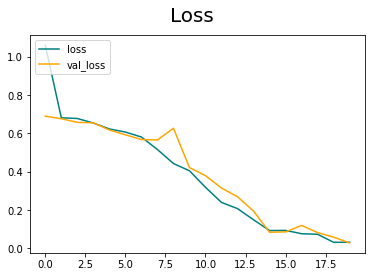

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

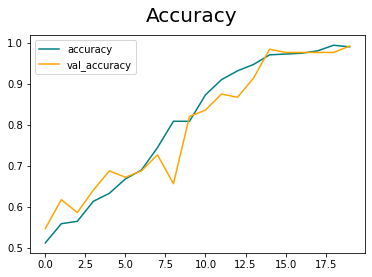

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate

In [36]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [38]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 154ms/step


In [39]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# Save the Model

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model.save(os.path.join('models','imageclassifier.h5'))

# Test the model

In [49]:
import cv2

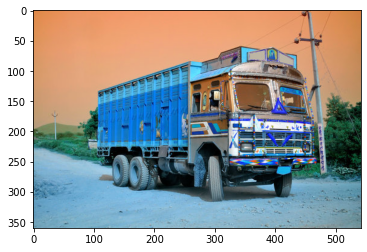

In [50]:
img = cv2.imread('images.jpg')
plt.imshow(img)
plt.show()

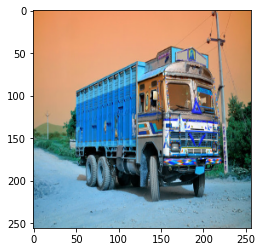

In [51]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [52]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 41ms/step


In [53]:
yhat

array([[0.97098464]], dtype=float32)

In [54]:
if yhat > 0.5: 
    print(f'Predicted class is truck')
else:
    print(f'Predicted class is car')

Predicted class is truck
